# Modelo 2: Ajustes do Artigo BackProp

# Importação de Variáveis e Indicadores

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

btc = pd.read_excel("../wrangled_data/serie_bitcoin.xlsx", index_col = "Data")
variaveis = pd.read_excel("../wrangled_data/variaveis.xlsx", index_col = "Data")

# Período de Treinamento e Teste

In [97]:
# Período de Treinamento
ini_treino = "2014-02-01"
fim_treino = "2017-05-17"

# Período de Teste
ini_teste = "2017-05-18"
fim_teste = "2021-07-31"

#### Stop Fixo por operação

In [98]:
stop_fixo = pd.DataFrame()
stop_fixo["Retorno"] = btc["Fechamento"].pct_change()
stop_fixo["Alvo_Contínuo"] = pd.Series(stop_fixo["Retorno"])
stop_fixo["Alvo_Binário"] = np.where(stop_fixo["Retorno"] > 0, 1, 0)

STOP = 0.2
stop_fixo["Stop_Long"] = np.where(btc["Abertura"]/btc["Mínima"] > (1+STOP), 1, 0)
stop_fixo["Stop_Short"] = np.where(btc["Máxima"]/btc["Abertura"] > (1+STOP), 1, 0)
stop_fixo[["Alvo_Contínuo", "Alvo_Binário", "Stop_Long", "Stop_Short"]] = stop_fixo[["Alvo_Contínuo", "Alvo_Binário", "Stop_Long", "Stop_Short"]].shift(-1) 
stop_fixo.dropna(inplace = True)

stop_fixo.head()

,Retorno,Alvo_Contínuo,Alvo_Binário,Stop_Long,Stop_Short
Data,,,,,
2010-07-18,0.733791,-0.058714,0.0,0.0,0.0
2010-07-19,-0.058714,-0.075083,0.0,0.0,0.0
2010-07-20,-0.075083,0.059902,1.0,0.0,0.0
2010-07-21,0.059902,-0.293713,0.0,1.0,0.0
2010-07-22,-0.293713,0.113296,1.0,0.0,1.0


#### Stop Ajustado pela Volatilidade

In [99]:
stop_vol = pd.DataFrame()
stop_vol["Retorno"] = btc["Fechamento"].pct_change()
stop_vol["Alvo_Contínuo"] = pd.Series(stop_vol["Retorno"]).shift(-1)
stop_vol["Alvo_Binário"] = np.where(stop_vol["Retorno"] > 0, 1, 0)

# Distâncias entre a abertura e os extremos do candle
stop_vol["d_max"] = (btc["Máxima"]/btc["Abertura"])-1
stop_vol["d_min"] = (btc["Abertura"]/btc["Mínima"])-1

# Desvio-padrão amostral das distâncias da série 
sd_d_max, sd_d_min = stop_vol["d_max"].std(), stop_vol["d_min"].std()

stop_vol["Stop_Short"] = np.where(stop_vol["d_max"] > 2*sd_d_max, 1, 0)
stop_vol["Stop_Short"] = stop_vol["Stop_Short"].shift()

stop_vol["Stop_Long"] = np.where(stop_vol["d_min"] > 2*sd_d_min, 1, 0)
stop_vol["Stop_Long"] = stop_vol["Stop_Long"].shift()
stop_vol.dropna(inplace = True)
stop_vol.drop(["d_max", "d_min"], axis = 1, inplace = True)
stop_vol.head()

,Retorno,Alvo_Contínuo,Alvo_Binário,Stop_Short,Stop_Long
Data,,,,,
2010-07-18,0.733791,-0.058714,1,0.0,0.0
2010-07-19,-0.058714,-0.075083,0,1.0,0.0
2010-07-20,-0.075083,0.059902,0,0.0,0.0
2010-07-21,0.059902,-0.293713,1,0.0,0.0
2010-07-22,-0.293713,0.113296,0,0.0,0.0


# Separação Treinamento - Teste

In [100]:
df = variaveis.join(stop_fixo)

X_train = variaveis[ini_treino:fim_treino]
y_train = np.where(df["Alvo_Binário"][ini_treino:fim_treino] == 1, 1, -1)

X_test = variaveis[ini_teste:fim_teste]
y_test = np.where(df["Alvo_Binário"][ini_teste:fim_teste] == 1, 1, -1)

#### Padronização

In [101]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_norm = scaler.fit_transform(X_train)
# X_test_norm = scaler.transform(X_test)

#### PCA

In [102]:
# from sklearn.decomposition import PCA

# pca = PCA()
# X_train = pca.fit_transform(X_train_norm)
# X_test = pca.transform(X_test_norm)
# pca.explained_variance_ratio_.cumsum().round(2)

# Modelagem

In [103]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### Otimização

Hiperparâmetros a serem otimizados:

* hidden_layer_sizes -> tupla contendo o número de neurônios dentro de cada camada (padrão: uma camada de 100 neurons)
* max_iter -> número máximo de iterações a serem realizadas pelo método de backpropagation
* alpha -> o valor máximo de alteração dos coeficientes em cada iteração, para minimizar a função de custo (padrão: 0.0001)
* solver -> Algoritmo utilizado para encontrar a solução ótima, cujo tempo de obtenção da resposta varia. Opções: 'lbfgs', 'sgd' e 'adam'.

# Ajustes:

* Incorporação de PCA e normalização
* Amostras de treino aleatórias
* Ativação: tangente hiperbólica
* Outputs -1 e 1
* Gradiente Descendente Estocástico
* Learning rate = adaptive
* alphas = np.logspace(-1, 1, 5)

#### Treinamento

In [104]:
# modelo = MLPClassifier(random_state = 42, shuffle = True, activation = "tanh", solver = "sgd", learning_rate = "adaptive")

# parametros = {'alpha': np.logspace(-1, 1, 20),
#               'max_iter': [5, 15, 25, 50, 100]}

# melhor_modelo = GridSearchCV(modelo, parametros, n_jobs = -1, cv = 10, scoring = "roc_auc")
# melhor_modelo.fit(X_train, y_train)

# print('Melhor conjunto de parâmetros:\n', melhor_modelo.best_params_)

In [105]:
melhor_modelo = MLPClassifier(random_state = 42, shuffle = True, activation = "tanh", solver = "sgd", learning_rate = "adaptive")
melhor_modelo.fit(X_train, y_train)

MLPClassifier(activation='tanh', learning_rate='adaptive', random_state=42,
              solver='sgd')

#### Teste

<AxesSubplot:title={'center':'Probabilidades'}>

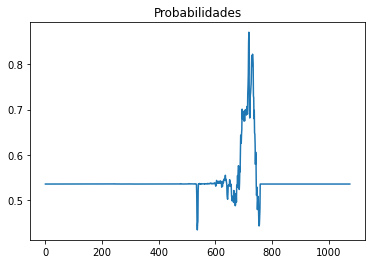

In [106]:
y_pred_train = melhor_modelo.predict(X_train)
y_pred_test = melhor_modelo.predict(X_test)

y_proba_train = melhor_modelo.predict_proba(X_train)[:,1]
y_proba_test = melhor_modelo.predict_proba(X_test)[:,1]
pd.Series(y_proba_test).plot(title = "Probabilidades")

#### Avaliação

In [107]:
# Treinamento
print(confusion_matrix(y_train, y_pred_train))
print()
print(accuracy_score(y_train, y_pred_train))
print()
print(classification_report(y_train, y_pred_train))

[[ 22 364]
 [ 22 436]]

0.542654028436019

              precision    recall  f1-score   support

          -1       0.50      0.06      0.10       386
           1       0.55      0.95      0.69       458

    accuracy                           0.54       844
   macro avg       0.52      0.50      0.40       844
weighted avg       0.52      0.54      0.42       844



In [108]:
# Teste
print(confusion_matrix(y_test, y_pred_test))
print()
print(accuracy_score(y_test, y_pred_test))
print()
print(classification_report(y_test, y_pred_test))

[[  8 494]
 [ 12 561]]

0.5293023255813953

              precision    recall  f1-score   support

          -1       0.40      0.02      0.03       502
           1       0.53      0.98      0.69       573

    accuracy                           0.53      1075
   macro avg       0.47      0.50      0.36      1075
weighted avg       0.47      0.53      0.38      1075



AUC - Teste : 0.46518289842375693


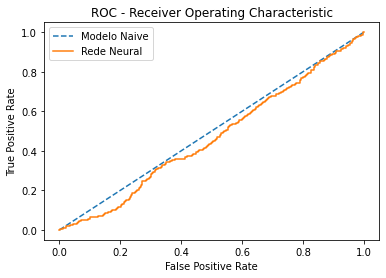

In [109]:
# Calculando a AUC (Area Under the Curve)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)
print("AUC - Teste :", roc_auc)

# Criando Curva ROC
plt.plot([0,1], [0,1], linestyle = '--', label = 'Modelo Naive')
plt.plot(fpr, tpr, label = 'Rede Neural')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC - Receiver Operating Characteristic")
plt.legend()
plt.show()

#### Sinais

In [110]:
n_q = 100

sinais = pd.DataFrame()
sinais["Observado"] = np.array(y_train)
sinais["Probabilidades"] = pd.Series(y_proba_train)
sinais["Quantil"] = pd.qcut(sinais["Probabilidades"], n_q, False)
sinais["Intervalo_Quantil"] = pd.qcut(sinais["Probabilidades"], n_q)

##### Automatização do Ponto de Corte

In [111]:
# Automatização 2:
pares = []
for i in range(n_q):
    for j in range(n_q):
        if i < j:
            pares.append((i,j))
            
def backtest(par):

    lim_venda = par[0]
    lim_compra = par[1]
    
    corte_compra = sinais[sinais["Quantil"] == lim_compra]["Intervalo_Quantil"].iloc[0].left
    corte_venda = sinais[sinais["Quantil"] == lim_venda]["Intervalo_Quantil"].iloc[0].right
    
    resultado = pd.DataFrame()
    resultado["Observado"] = np.array(y_train)
    resultado["Probabilidades"] = pd.Series(y_proba_train)
    resultado["Operação"] = np.where(resultado["Probabilidades"] > corte_compra, 1, np.where(resultado["Probabilidades"] < corte_venda, -1, 0))

    bt = pd.DataFrame()
    bt["Alvo"] = df["Alvo_Contínuo"][ini_treino:fim_treino].reset_index(drop = True)
    bt["Sinal"] = resultado["Operação"]
    bt.index = df["Alvo_Contínuo"][ini_treino:fim_treino].index
    bt["Retorno Diário"] = np.where(bt["Sinal"] == 1, bt["Alvo"], np.where(bt["Sinal"] == -1, -bt["Alvo"], 0))
    bt["Retorno Acumulado"] = (bt["Retorno Diário"] + 1).cumprod()

    return bt.tail(1)["Retorno Acumulado"].values

retornos = []
for i in pares:
    retornos.append(backtest(i))
    
print("Maior retorno no treinamento:", max(retornos))
print("Quantis de Corte", pares[retornos.index(max(retornos))])

lim_compra = pares[retornos.index(max(retornos))][1]
lim_venda = pares[retornos.index(max(retornos))][0]

corte_compra = sinais[sinais["Quantil"] == lim_compra]["Intervalo_Quantil"].iloc[0].left
corte_venda = sinais[sinais["Quantil"] == lim_venda]["Intervalo_Quantil"].iloc[0].right

Maior retorno no treinamento: [3.43273094]
Quantis de Corte (1, 59)


#### Backtest

Retorno BH: [621.81470973] %
Retorno do Modelo: [431.73321526] %


<AxesSubplot:xlabel='Data'>

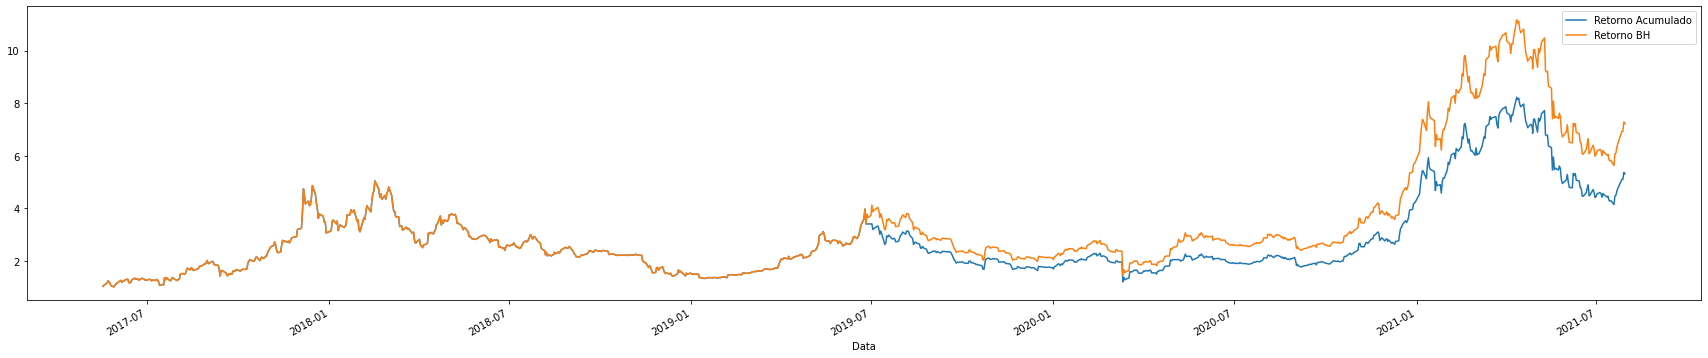

In [114]:
resultado = pd.DataFrame()
resultado["Observado"] = np.array(y_test)
resultado["Probabilidades"] = pd.Series(y_proba_test)
resultado["Operação"] = np.where(resultado["Probabilidades"] > corte_compra, 1, np.where(resultado["Probabilidades"] < corte_venda, -1, 0))
resultado["Operação"].value_counts()

bt = pd.DataFrame()
bt["Alvo"] = df["Alvo_Contínuo"][ini_teste:fim_teste].reset_index(drop = True)
bt["Sinal"] = resultado["Operação"]
bt.index = df["Alvo_Contínuo"][ini_teste:fim_teste].index

# Acrescentando Stop
# bt = bt.join(df[["Stop_Long", "Stop_Short"]])
# bt["Retorno Long"] = np.where(bt["Sinal"] == 1, bt["Alvo"], 0)
# bt["Retorno Short"] = np.where(bt["Sinal"] == -1, -bt["Alvo"], 0)
# bt["Retorno Long"] = np.where(bt["Stop_Long"] == 1, -STOP, bt["Retorno Long"])
# bt["Retorno Short"] = np.where(bt["Stop_Short"] == 1, -STOP, bt["Retorno Short"])
# bt["Retorno Diário"] = bt["Retorno Long"] + bt["Retorno Short"]

bt["Retorno Diário"] = np.where(bt["Sinal"] == 1, bt["Alvo"], np.where(bt["Sinal"] == 0, bt["Alvo"], 0))

bt["Retorno Acumulado"] = (bt["Retorno Diário"] + 1).cumprod()
bt["Retorno BH"] = (bt["Alvo"] + 1).cumprod()

print("Retorno BH:", (bt.tail(1)["Retorno BH"].values-1)*100, "%")
print("Retorno do Modelo:", (bt.tail(1)["Retorno Acumulado"].values-1)*100, "%")

bt[["Retorno Acumulado", "Retorno BH"]].plot(figsize=(30,6))

In [113]:
bt.to_excel("../wrangled_data/backtest.xlsx")